In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import warnings
from math import sqrt
from datetime import datetime

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import dateutil.rrule as rr 

from ts_viz import TimeSeriesViz

TODO: switch to https://github.com/CSSEGISandData/COVID-19

In [27]:
csv_url = 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv'
date_parser = lambda s: datetime.strptime(s+ '-3', '%Y-%W-%u')
df_raw = pd.read_csv(csv_url, parse_dates=['year_week'], date_parser=date_parser, index_col=['year_week'])
df_raw.index.name = 'date'
df_raw[df_raw['country'] == 'Hungary'].tail()

,country,country_code,continent,population,indicator,weekly_count,rate_14_day,cumulative_count,source
date,,,,,,,,,
2020-12-16,Hungary,HUN,Europe,9772756,deaths,1146,236.064422,7130,"Epidemic intelligence, national weekly data"
2020-12-23,Hungary,HUN,Europe,9772756,deaths,1152,235.143495,8282,"Epidemic intelligence, national weekly data"
2020-12-30,Hungary,HUN,Europe,9772756,deaths,879,207.822645,9161,"Epidemic intelligence, national weekly data"
2021-01-06,Hungary,HUN,Europe,9772756,deaths,816,173.441351,9977,"Epidemic intelligence, national weekly data"
2021-01-06,Hungary,HUN,Europe,9772756,deaths,748,160.036739,10725,"Epidemic intelligence, national weekly data"


In [22]:
# yesterday = True

# day = (dt.datetime.now() - dt.timedelta(days=1 if yesterday else 0)).strftime('%Y-%m-%d')
# world_url =  'https://www.ecdc.europa.eu/sites/default/files/documents/'\
#             f'COVID-19-geographic-disbtribution-worldwide-{day}.xlsx'
# print('Downloading:', world_url)
# date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
# df_raw = pd.read_excel(world_url, parse_dates=['dateRep'], index_col=0)
# print(f'Last day with data: {df_raw.index.max():%Y-%m-%d}')
# df_raw = df_raw[['cases', 'deaths', 'countriesAndTerritories']]
# df_raw.columns = ['cases', 'deaths', 'country']
# df_raw = df_raw.sort_index()
# df_raw[df_raw['country'] == 'Hungary'].tail()

In [25]:
df_raw['indicator'].unique()

array(['cases', 'deaths'], dtype=object)

In [ ]:
df.to_csv(f'data/world-{day}.csv')

In [34]:
class FitFunc:
    def __init__(self, func, name, disp_eq, params_name, params_init, maxfev=2000, validator=None):
        self.func = func
        self.name = name
        self.disp_eq = disp_eq
        self.params_name = params_name
        self.params_init = params_init
        self.maxfev = maxfev
        self.validator = validator
    
    def fit_timeseries(self, series, pred=7, rmse_ma_window=1):
        x = np.arange(len(series))
        index = pd.date_range(series.index.min(), periods=(len(series) + pred), freq='D')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            popt, pcov = curve_fit(self.func, x, series.values, maxfev=self.maxfev, p0=self.params_init)
        if callable(self.validator) and not self.validator(popt):
            return (None, None, None, None, popt)
        y = self.func(np.arange(len(index)), *popt)
        fit = pd.Series(y, index=index)
        rmse_pred = series.rolling(window=rmse_ma_window, center=True, min_periods=1).mean().values
        rmse = sqrt(mean_squared_error(y[x], rmse_pred))
        max_idx = fit.index[np.argmax(fit)]
        max_val = fit[max_idx]
        return (fit, rmse, max_idx, max_val, popt)

power_func = FitFunc(
    func=lambda t, K, x, t0, b: K * np.power(t, x) * np.exp(-t / t0) + b,
    name='power law',
    disp_eq='$n(t)=Kt^{{x}}e^{{-t/t_0}}+b$',
    params_name=['K', 'x', 't_0', 'b'],
    params_init=[1, 1, 5, 0],
    maxfev=10000,
    validator=lambda popt: (popt[0] > 0)
)

def month_week_ticks(start, end):
    rrset = rr.rruleset()
    monthstarts_rule = rr.rrule(rr.DAILY, bymonthday=1, dtstart=start, until=end)
    weekstarts_rule = rr.rrule(rr.DAILY, byweekday=rr.MO, dtstart=start, until=end) 
    rrset.rrule(weekstarts_rule)
    rrset.rrule(monthstarts_rule)
    monthstarts = list(monthstarts_rule)
    weekstarts = list(weekstarts_rule)
    monthweekstarts = list(rrset)
    labels = [f'|\n{d:%b}' if d in monthstarts else f'{d.day}' for d in monthweekstarts]
    return monthweekstarts, labels

class Diag:
    def __init__(self, series, series_name=None, figsize=(16, 10)):
        self.series = series
        self.figsize = figsize
        self.series_name = series_name if series_name else series.name
        self.title_lines = [self.series_name]
    
    def __enter__(self):
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.ax.yaxis.grid(True, which='major')
        ticks, labels = month_week_ticks(self.series.index.min(), self.series.index.max())
        self.ax.set_xticks(ticks)
        self.ax.set_xticklabels(labels)
        self.ax.xaxis.set_minor_locator(mdates.DayLocator())
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.ax.set_title(self.series_name)
        self.ax.legend()
        self.ax.set_title('\n'.join(self.title_lines))
        plt.show()
    
    def show_series(self):
        self.ax.bar(self.series.index, self.series, align='center', label='data')
    
    def show_ma(self, window=7, center=True, color='tab:orange', lw=3):
        ma = self.series.rolling(window=window, center=center).mean()
        self.ax.plot(ma.index, ma, label=f'{window} days moving average', color=color, lw=lw)
    
    def show_fit(self, fit_func, pred=7, color='tab:red', lw=3):
        (fit, rmse, max_idx, max_val, popt) = fit_func.fit_timeseries(self.series, pred)
        print(f'{fit_func.name} fit:')
        format_num = lambda x: f'{x:.02e}' if x < 0.005 else f'{x:.02f}'
        params_str = ', '.join([f'{k} = {format_num(v)}' for k, v in zip(fit_func.params_name, popt)])
        print(f'    params: {params_str}')
        if fit is not None:
            self.ax.plot(fit.index, fit, label=f'{fit_func.name} fit', color=color, lw=lw)
            self.ax.axvline(max_idx, color=color, lw=lw)
            self.title_lines.append(f'Fit function: {fit_func.name}, {fit_func.disp_eq}')
            print(f'    RMSE = {rmse:.02f}')
            print(f'    peak day: {max_idx:%Y-%m-%d}, value = {max_val:.0f}')
        else:
            print('    Could not find valid fit.')

In [60]:
get_kwarg = lambda kw, k, d: kw[k] if k in kw else d

class CountryViz:
    def __init__(self, df_raw, fit_func, start=None, end=None, pred=7, ma_window=7):
        self.df_raw = df_raw
        self.fit_func = fit_func
        self.start = start
        self.end = end
        self.pred = pred
        self.ma_window = ma_window
        
    def _get_series(self, country, column, **kwargs):
        df = self.df_raw[(df_raw['country'] == country) & (df_raw['indicator'] == column)].sort_index()
        series = df['cumulative_count']
        series = series - series.shift()
        start = kwargs['start'] if 'start' in kwargs else self.start
        end = kwargs['end'] if 'end' in kwargs else self.end
        if start:
            series = series[series.index >= start]
        if end:
            series = series[series.index <= end]
        return series

    def _show_diag(self, country, column, name, **kwargs):
        pred = get_kwarg(kwargs, 'pred', self.pred)
        show_series = get_kwarg(kwargs, 'show_series', True)
        show_ma = get_kwarg(kwargs, 'show_ma', True)
        show_fit = get_kwarg(kwargs, 'show_fit', True)
        series = self._get_series(country, column, **kwargs)
        series.name = f'{name} in {country}'
        with Diag(series) as diag:
            if show_series:
                diag.show_series()
            if show_ma:
                diag.show_ma(window=self.ma_window)
            if show_fit:
                diag.show_fit(self.fit_func, pred=pred)

    def show_deaths(self, country, **kwargs):
        self._show_diag(country, 'deaths', 'Daily deaths', **kwargs)
    
    def show_cases(self, country, **kwargs):
        self._show_diag(country, 'cases', 'Daily cases', **kwargs)

In [61]:
viz = CountryViz(df_raw, power_func)

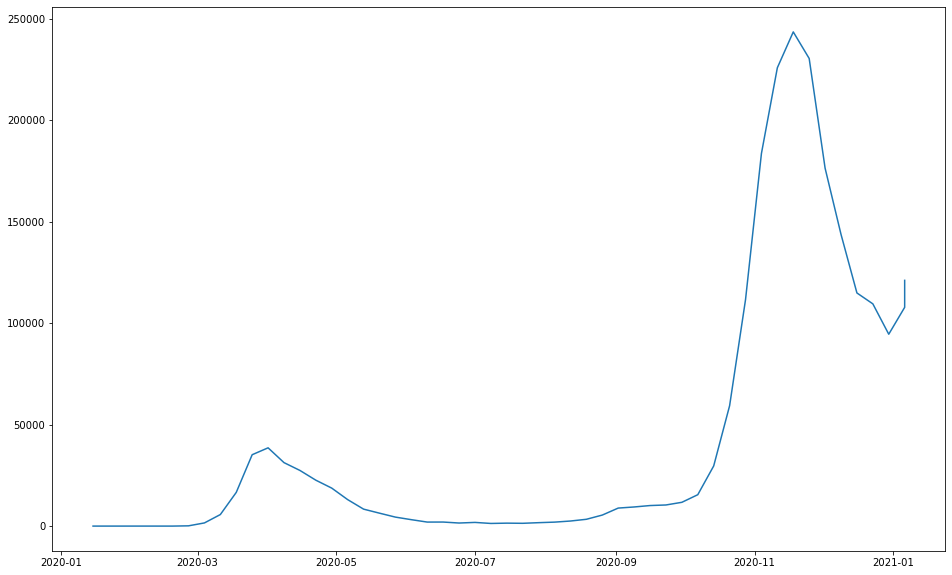

In [62]:
series = viz._get_series('Italy', 'cases')
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(series.index, series, label='data')
# loc = mdates.WeekdayLocator(mdates.WE)
# ax.xaxis.set_minor_locator(mdates.WeekdayLocator(mdates.WE))
# ax.xaxis_date()

power law fit:
    params: K = 41714.68, x = 0.52, t_0 = -9.80e+07, b = -2.38e+04
    RMSE = 59517.48
    peak day: 2020-09-28, value = 202455


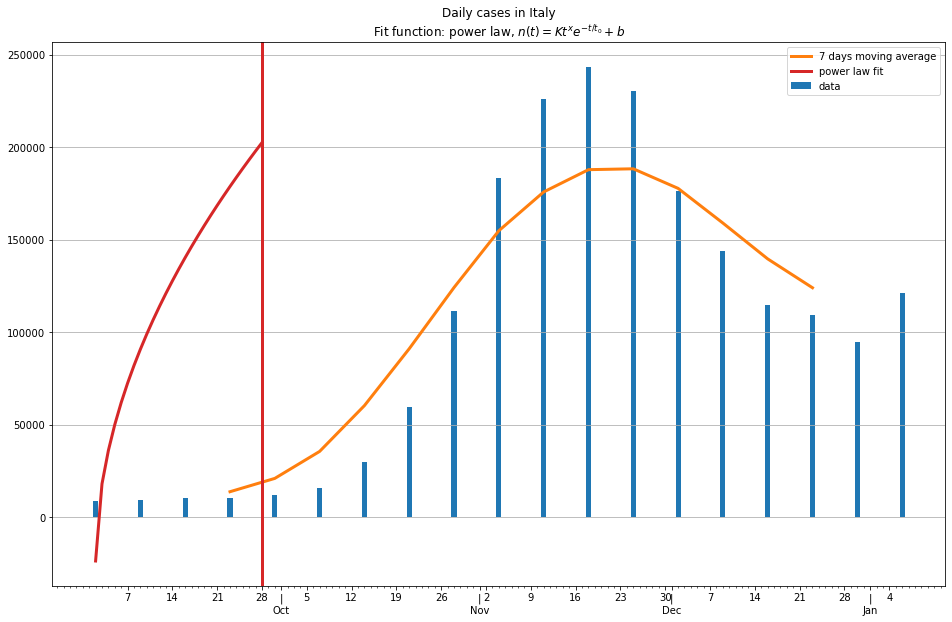

In [64]:
viz.show_cases('Italy', start='2020-09-01', show_ma=False, show_fit=False)

In [ ]:
viz.show_deaths('Italy', start='2020-10-01')

In [ ]:
viz.show_cases('France', start='2020-09-01')

In [ ]:
viz.show_deaths('France', start='2020-09-15')

In [ ]:
viz.show_cases('Hungary', start='2020-09-15')

In [ ]:
viz.show_deaths('Hungary', start='2020-10-01')

In [ ]:
viz.show_cases('Belgium', start='2020-09-01')

In [ ]:
viz.show_deaths('Belgium', start='2020-10-01')

In [ ]:
viz.show_cases('Spain', start='2020-09-01')

In [ ]:
viz.show_deaths('Spain', start='2020-09-15')

In [ ]:
viz.show_cases('United_Kingdom', start='2020-09-01')

In [ ]:
viz.show_deaths('United_Kingdom', start='2020-09-15')

In [ ]:
viz.show_cases('United_States_of_America', start='2020-09-01', pred=14)

In [ ]:
viz.show_deaths('United_States_of_America', start='2020-10-01', pred=14)

In [ ]:
viz.show_cases('Sweden', start='2020-10-01')

In [ ]:
viz.show_deaths('Sweden', start='2020-10-15')

In [ ]:
viz.show_cases('Germany', start='2020-09-15')

In [ ]:
viz.show_deaths('Germany', start='2020-10-01')

In [ ]:
viz.show_cases('Iceland', start='2020-09-01')

In [ ]:
viz.show_cases('Singapore', start='2020-07-01')

In [ ]:
viz.show_cases('South_Korea', start='2020-10-15')

In [ ]:
viz.show_cases('Japan', start='2020-09-15', pred=30)

In [ ]:
viz.show_cases('Brazil', start='2020-04-01')

In [ ]:
viz.show_deaths('Brazil', start='2020-04-01')

In [ ]:
viz.show_cases('Russia', start='2020-08-15', pred=60)

In [ ]:
viz.show_deaths('Russia', start='2020-09-15', pred=150)

In [ ]:
viz.show_cases('Romania', start='2020-09-01')

In [ ]:
viz.show_deaths('Romania', start='2020-10-01')

In [ ]:
viz.show_cases('Ukraine', start='2020-08-01')

In [ ]:
viz.show_deaths('Ukraine', start='2020-08-01')

In [ ]:
viz.show_cases('Iran', start='2020-10-01', pred=30)

In [ ]:
viz.show_deaths('Iran', start='2020-09-01', pred=30)

In [ ]:
viz.show_cases('Czechia', start='2020-09-15')

In [ ]:
viz.show_deaths('Czechia', start='2020-09-15')

In [ ]:
viz.show_cases('South_Africa', start='2020-04-15')

In [ ]:
viz.show_cases('India', start='2020-04-15')

In [ ]:
# fig, ax = CountryViz('Chile', '2020-02-15', df_raw).show_cases()
# ax.set_ylim(None, 8000)

In [ ]:
# CountryViz('Australia', '2020-02-15', df_raw).show_cases()

In [ ]:
# CountryViz('New_Zealand', '2020-02-15', df_raw).show_cases()

In [ ]:
# CountryViz('Canada', '2020-02-15', df_raw).show_cases()

In [ ]:
# india = CountryViz('India', '2020-02-15', df_raw)
# india.show_cases()

In [ ]:
# india.show_deaths()

In [ ]:
# fig, ax = CountryViz('China', '2020-01-01', df_raw).show_cases()
# ax.set_ylim(0, 5000)

In [ ]:
# fig, ax = CountryViz('Belgium', '2020-01-01', df_raw).show_cases()

In [ ]:
sorted(df_raw['country'].unique())

In [ ]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(16, 10))
country = 'China'
start = '2020-01-15'
end = '2020-03-01'
country_df = df_raw[(df_raw['country'] == country) & (df_raw.index > start) & (df_raw.index < end)].sort_index()
ax.set_title('Total cases of COVID-19 in China')
cases_exp = country_df['cases'].expanding().sum()
ax.plot(cases_exp)

ann_start = '2020-02-12'
ann_stop = '2020-02-13'

ann_center_x = (mdates.datestr2num(ann_start) + mdates.datestr2num(ann_stop)) / 2
ann_center_y = (cases_exp[ann_start] + cases_exp[ann_stop]) / 2
ann_zoom = 1.5
ann_height = (cases_exp[ann_stop] - cases_exp[ann_start]) * ann_zoom
timespan = mdates.datestr2num(ann_stop) - mdates.datestr2num(ann_start)
ann_width = timespan * 2 * ann_zoom
ellipse = Ellipse(xy=(ann_center_x, ann_center_y), width=ann_width, height=ann_height, edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ax.annotate('China changed\ncase definition',
            xy=(ann_center_x, ann_center_y), xycoords='data',
            xytext=(50, -100), textcoords='offset points',
            size=15,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none",
                            patchB=ellipse,
                            connectionstyle="arc3,rad=0.3"))

plt.show()